In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter  # Import ScalarFormatter
import uproot
sys.path.append("../")
import saq
import glob


Welcome to JupyROOT 6.28/06


In [17]:
help(glob)

Help on module glob:

NAME
    glob - Filename globbing utility.

MODULE REFERENCE
    https://docs.python.org/3.10/library/glob.html
    
    The following documentation is automatically generated from the Python
    source files.  It may be incomplete, incorrect or include features that
    are considered implementation detail and may vary between Python
    implementations.  When in doubt, consult the module reference at the
    location listed above.

FUNCTIONS
    escape(pathname)
        Escape all special characters.
    
    glob(pathname, *, root_dir=None, dir_fd=None, recursive=False)
        Return a list of paths matching a pathname pattern.
        
        The pattern may contain simple shell-style wildcards a la
        fnmatch. However, unlike fnmatch, filenames starting with a
        dot are special cases that are not matched by '*' and '?'
        patterns.
        
        If recursive is true, the pattern '**' will match any files and
        zero or more directori

In [2]:
#Use the function glob() in the glob libary to obtain a list of paths matching a pathname pattern
root_file_paths = sorted(glob.glob('/home/wwz/saq_analysis/calibration/11_09_2023_complete_calibration/*.root'))
#sorted(root_file_paths)
print(sorted(root_file_paths))


# Initialize lists to store data for each file
timestamps_list = []
masks_list = []

# Define constants
clock_rate = 30.3e6
nn = 0
cutoff = (2**32) - 1
loop_time = cutoff / clock_rate

real_channel =[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

# Iterate through each root file
for j, root_file_path in enumerate(root_file_paths):
    # Open the ROOT file
    file = uproot.open(root_file_path)

    # Access the tree from the ROOT file
    tree = file["tt"]  # 'tt' is the name of the data tree in the root file

    # Convert the tree data into a dictionary
    data = tree.arrays(library="np")

    # Get timestamps from the data
    timestamps = data["Timestamp"]
    mask = data["ChMask"]
    print(len(timestamps))
    #print(len(mask))

    #print(timestamps[:10])
    #print(mask[:10])
    
    #filtered_timestamps =[]
    #for i in range(len(timestamps)):
        #if mask[i] == 2**(ch-1):
            #filtered_timestamps.append(timestamps[i]
    
    #This line does the same thing as the loop above, but in a more consice and Pythonic way
    filtered_timestamps = [timestamps[i] for i in range(5, len(timestamps)) if mask[i] == 2**(real_channel[j]-1)]
    
    print(len(filtered_timestamps))
    #print(filtered_timestamps[:10])

    # Initialize an array to store time in seconds
    time_sec = np.zeros(len(filtered_timestamps))

    # Convert the individual entries to show the time in seconds
    for i in range(len(filtered_timestamps)):
        time_sec[i] = filtered_timestamps[i] / clock_rate + (nn * loop_time)
        if i > 0 and filtered_timestamps[i] < filtered_timestamps[i - 1]:
            nn += 1
            time_sec[i] = float(filtered_timestamps[i] / clock_rate) + float(nn * loop_time)

    # Store the time_sec array in a list
    timestamps_list.append(time_sec)
    masks_list.append(data["ChMask"])

    nn=0

['/home/wwz/saq_analysis/calibration/11_09_2023_complete_calibration/11_09_2023_12_59_52.root', '/home/wwz/saq_analysis/calibration/11_09_2023_complete_calibration/11_09_2023_13_03_17.root', '/home/wwz/saq_analysis/calibration/11_09_2023_complete_calibration/11_09_2023_13_06_52.root', '/home/wwz/saq_analysis/calibration/11_09_2023_complete_calibration/11_09_2023_13_08_14.root', '/home/wwz/saq_analysis/calibration/11_09_2023_complete_calibration/11_09_2023_13_11_34.root', '/home/wwz/saq_analysis/calibration/11_09_2023_complete_calibration/11_09_2023_13_14_41.root', '/home/wwz/saq_analysis/calibration/11_09_2023_complete_calibration/11_09_2023_13_16_26.root', '/home/wwz/saq_analysis/calibration/11_09_2023_complete_calibration/11_09_2023_13_18_03.root', '/home/wwz/saq_analysis/calibration/11_09_2023_complete_calibration/11_09_2023_13_19_32.root', '/home/wwz/saq_analysis/calibration/11_09_2023_complete_calibration/11_09_2023_13_20_58.root', '/home/wwz/saq_analysis/calibration/11_09_2023_co

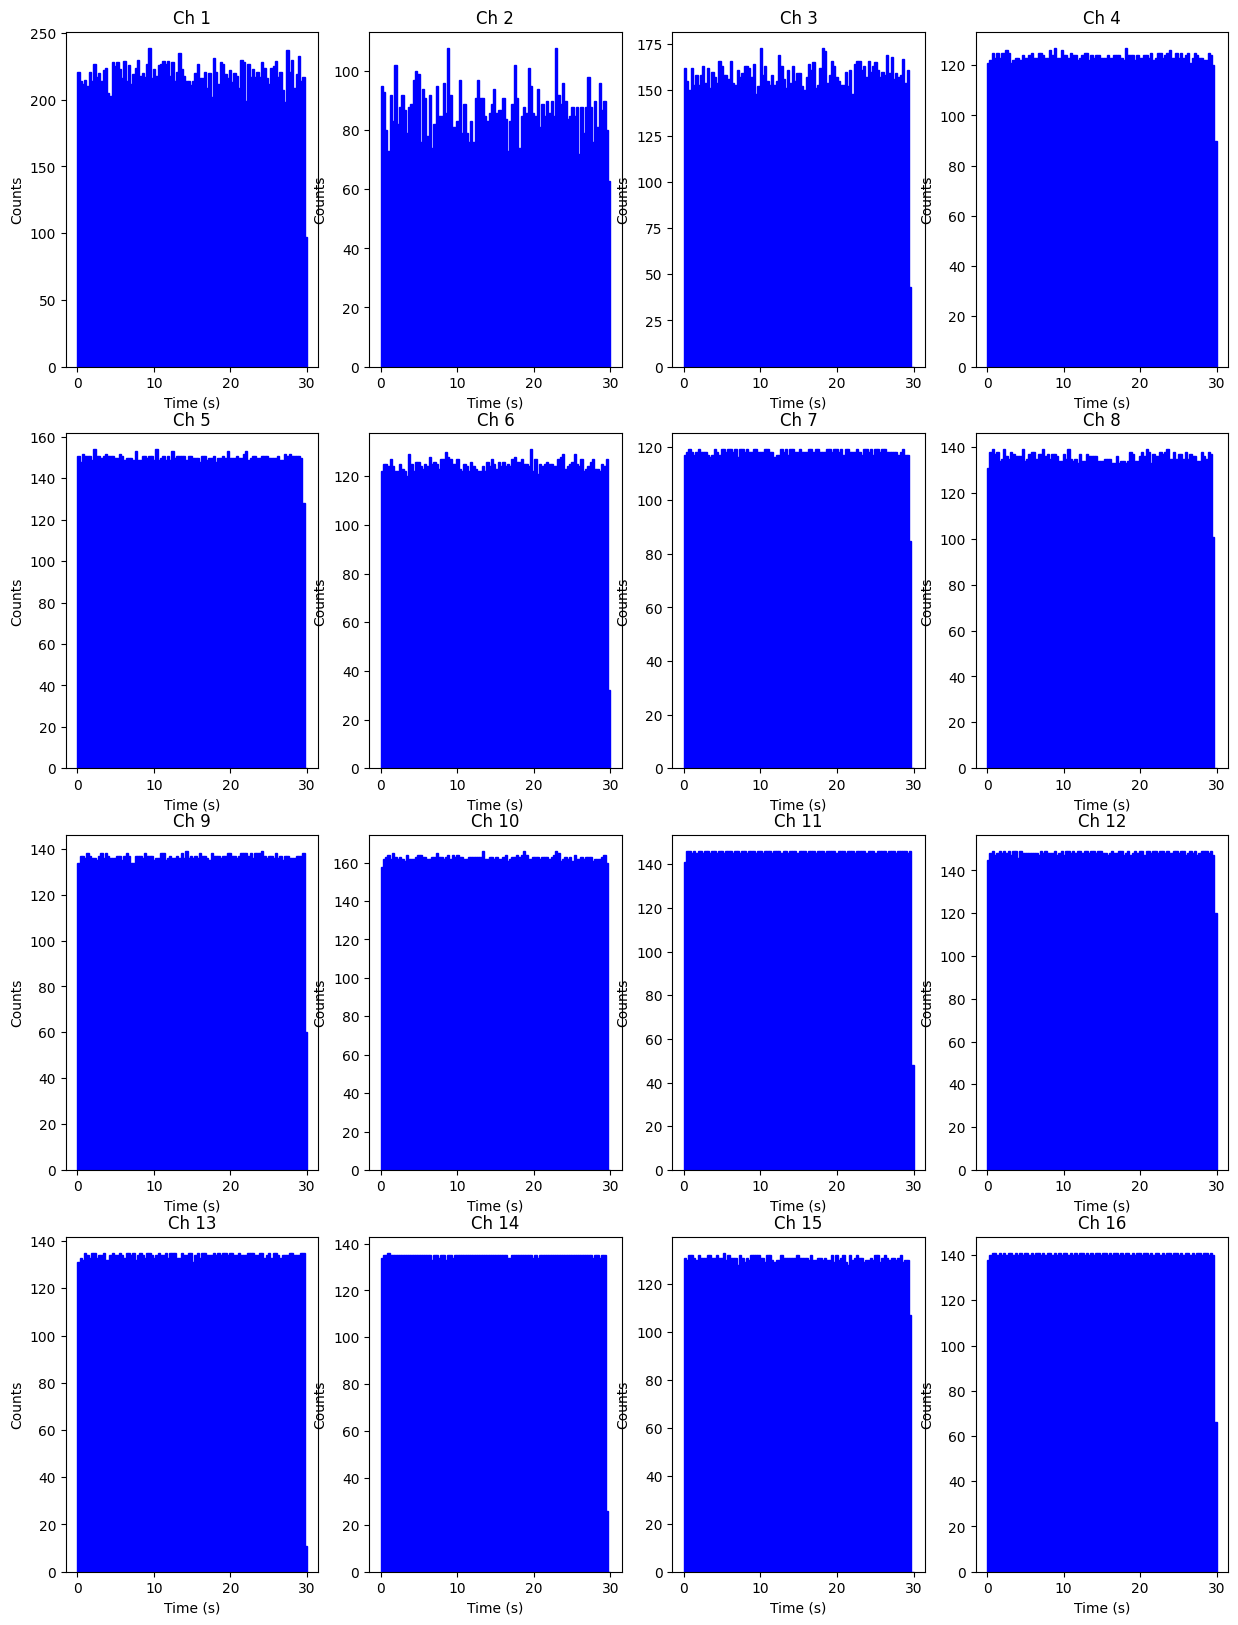

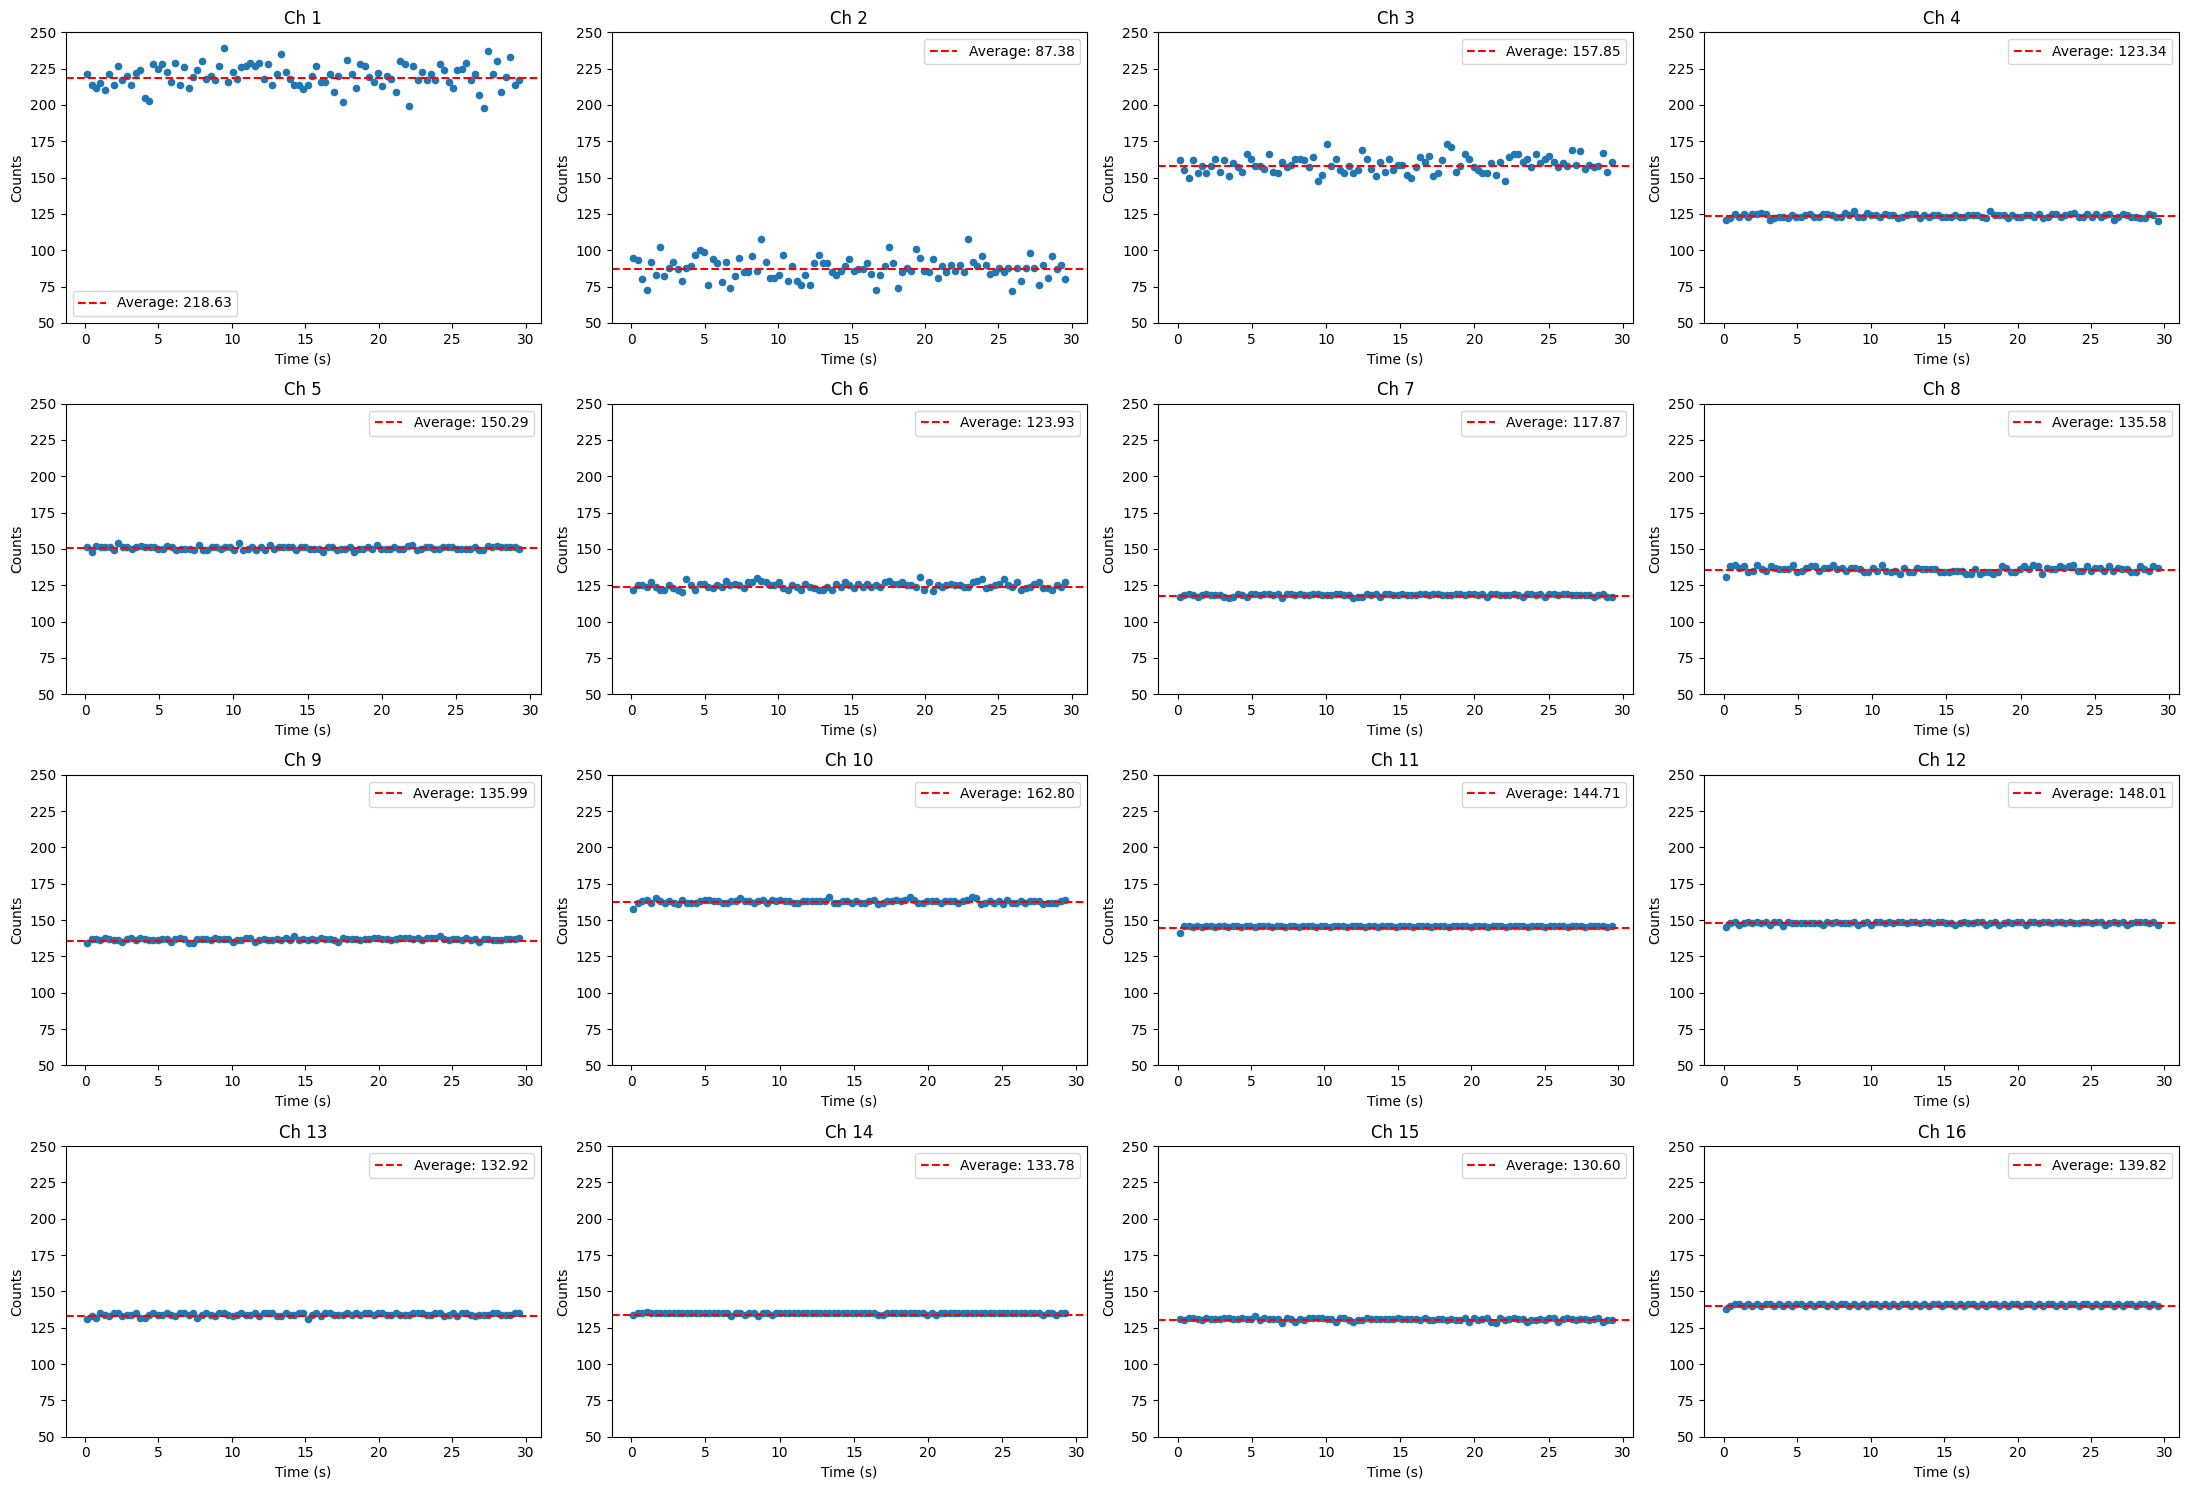

In [3]:
# Create a figure with a 3x5 grid of subplots
fig, axes = plt.subplots(4, 4, figsize=(15, 20))

# Create lists to store bin content from each histogram
bin_contents = []
bin_center=[]

# Create lists to store averages for each channel
averages = []

# Loop through your data and create histograms
for i in range(16):
    row = i // 4
    col = i % 4
    ax = axes[row, col]

    # Create the histogram and plot for the "timestamp" data
    hist, bins, _ = ax.hist(timestamps_list[i], range=(0, 30), bins=100, color='blue', alpha=1, edgecolor='blue')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Counts')
    ax.set_title(f'Ch {i+1}')

  # Store the bin content in the bin_contents list
    bin_contents.append(hist)
    bin_center.append(bins)

# Create a new 3x5 subplot grid to display the scatter plots of bin content
fig2, axes2 = plt.subplots(4, 4, figsize=(22, 15))

for i, content in enumerate(bin_contents):
    # Calculate the center of each bin
    bin_centers = (bin_center[i][:-1] + bin_center[i][1:]) / 2

    # Filter out bins with zero bin content
    non_zero_bins = content != 0
    avg = np.mean(content[non_zero_bins])
    averages.append(avg)

    # Scatter plot of non-zero bin content in the new subplot grid with specified range
    row = i // 4
    col = i % 4
    ax2 = axes2[row, col]
    ax2.scatter(bin_centers[non_zero_bins][:-1], content[non_zero_bins][:-1], marker='o', s=20)

    # Draw the average line on the scatter plot
    ax2.axhline(y=averages[i], color='red', linestyle='--', label=f'Average: {averages[i]:.2f}')

    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Counts')
    ax2.set_title(f'Ch {i + 1}')
    ax2.set_ylim(50, 250)
    ax2.legend()

plt.tight_layout()
plt.show()

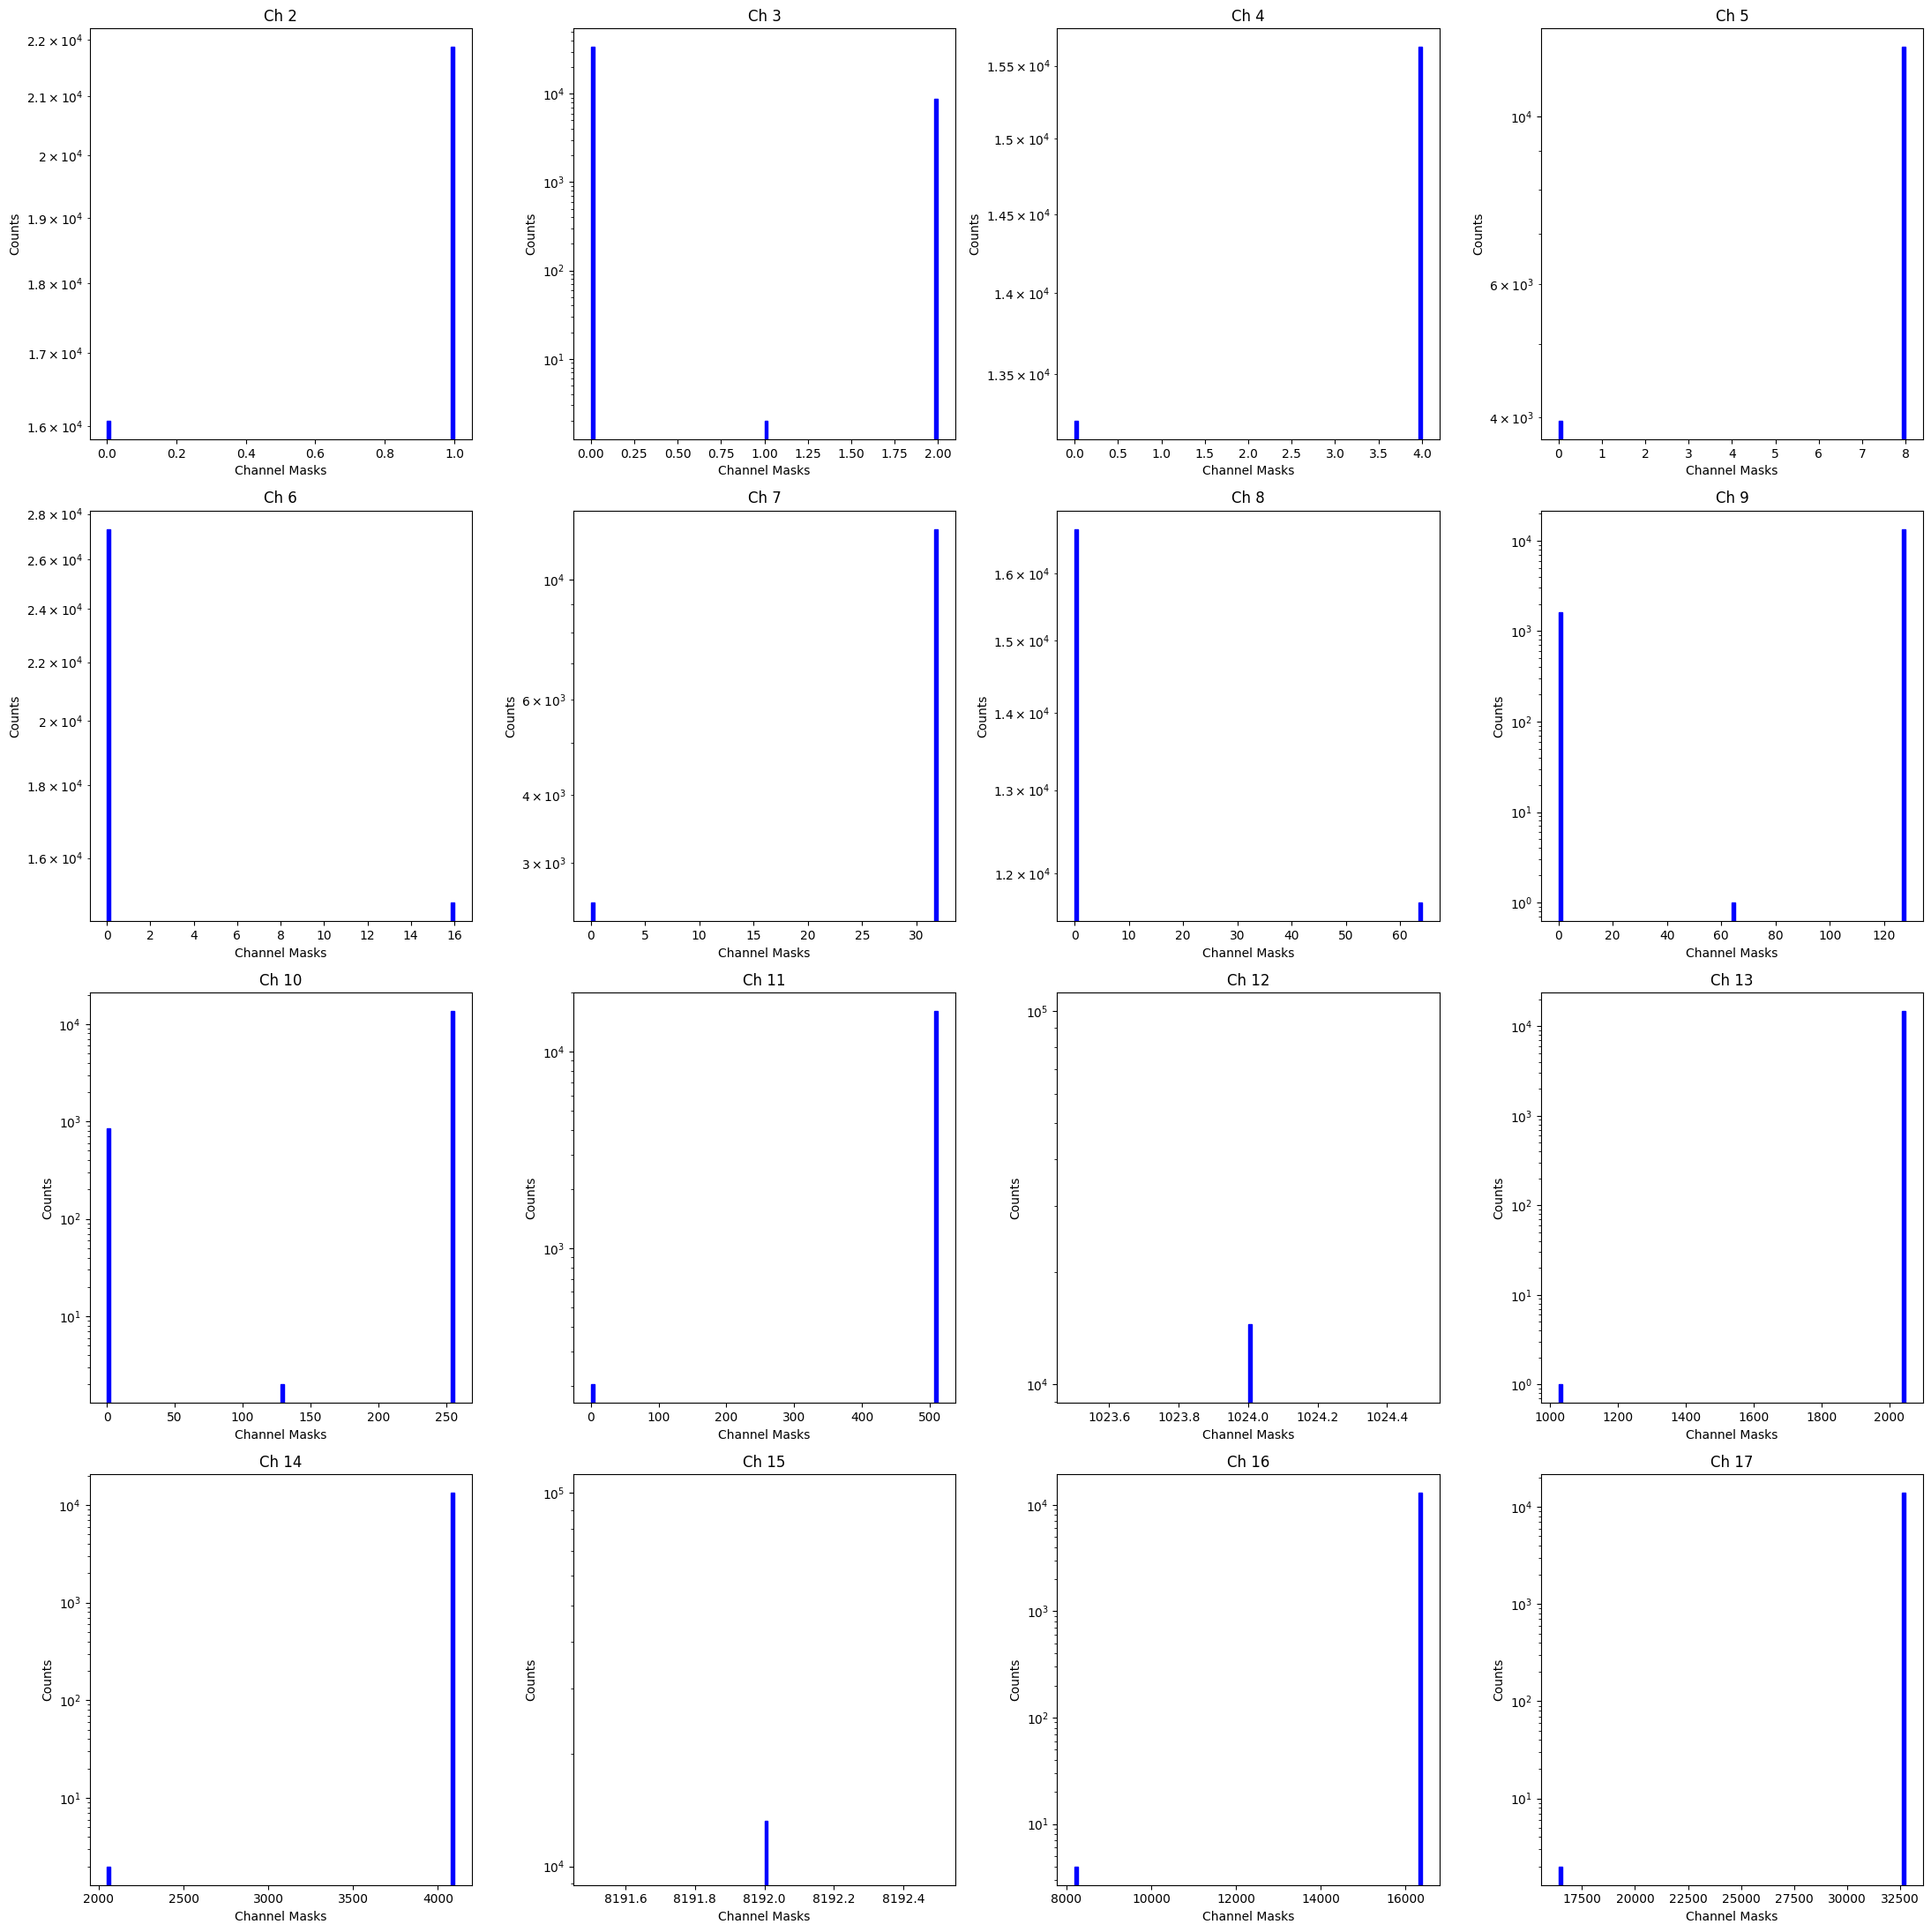

In [4]:
# Create a figure with a 3x5 grid of subplots
fig, axes = plt.subplots(4, 4, figsize=(22, 22))

# Loop through your data and create histograms
for i in range(16):
    row = i // 4
    col = i % 4
    ax = axes[row, col]

    # Create the histogram and plot for the "timestamp" data
    hist, bins, _ = ax.hist(masks_list[i], bins=100, color='blue', alpha=1, edgecolor='blue')
    ax.set_xlabel('Channel Masks')
    ax.set_ylabel('Counts')
    ax.set_yscale('log')
    #ax.set_xscale('log')
    ax.set_title(f'Ch {i + 2}')

#axes[0, 0].set_title('Ch 2')
#axes[0, 1].set_title('Ch 14')

plt.tight_layout()
plt.show()

ch 1  ,mean rtd:  2.156328479485693  ,std rtd:  0.1700349626929729
ch 2  ,mean rtd:  5.733196790018784  ,std rtd:  0.26305396592890007
ch 3  ,mean rtd:  2.260031684383437  ,std rtd:  0.23559864526382593
ch 4  ,mean rtd:  2.4408128729301564  ,std rtd:  0.18713173046818002
ch 5  ,mean rtd:  1.998076822841966  ,std rtd:  0.14762499382425193
ch 6  ,mean rtd:  2.4691405781805864  ,std rtd:  0.15987443297113396
ch 7  ,mean rtd:  2.5375559144018625  ,std rtd:  0.14864133500971347
ch 8  ,mean rtd:  2.2603891104977083  ,std rtd:  0.1115848303155014
ch 9  ,mean rtd:  2.193321836301883  ,std rtd:  0.20837450089125759
ch 10  ,mean rtd:  1.8541870893530292  ,std rtd:  0.0068468720772679615
ch 11  ,mean rtd:  2.0585778633841265  ,std rtd:  0.006581928015252009
ch 12  ,mean rtd:  2.0226393341361164  ,std rtd:  0.09560349314915997
ch 13  ,mean rtd:  2.2357010314679804  ,std rtd:  0.15076769673293774
ch 14  ,mean rtd:  2.2240611628934546  ,std rtd:  0.06483261145471605
ch 15  ,mean rtd:  2.293112559941

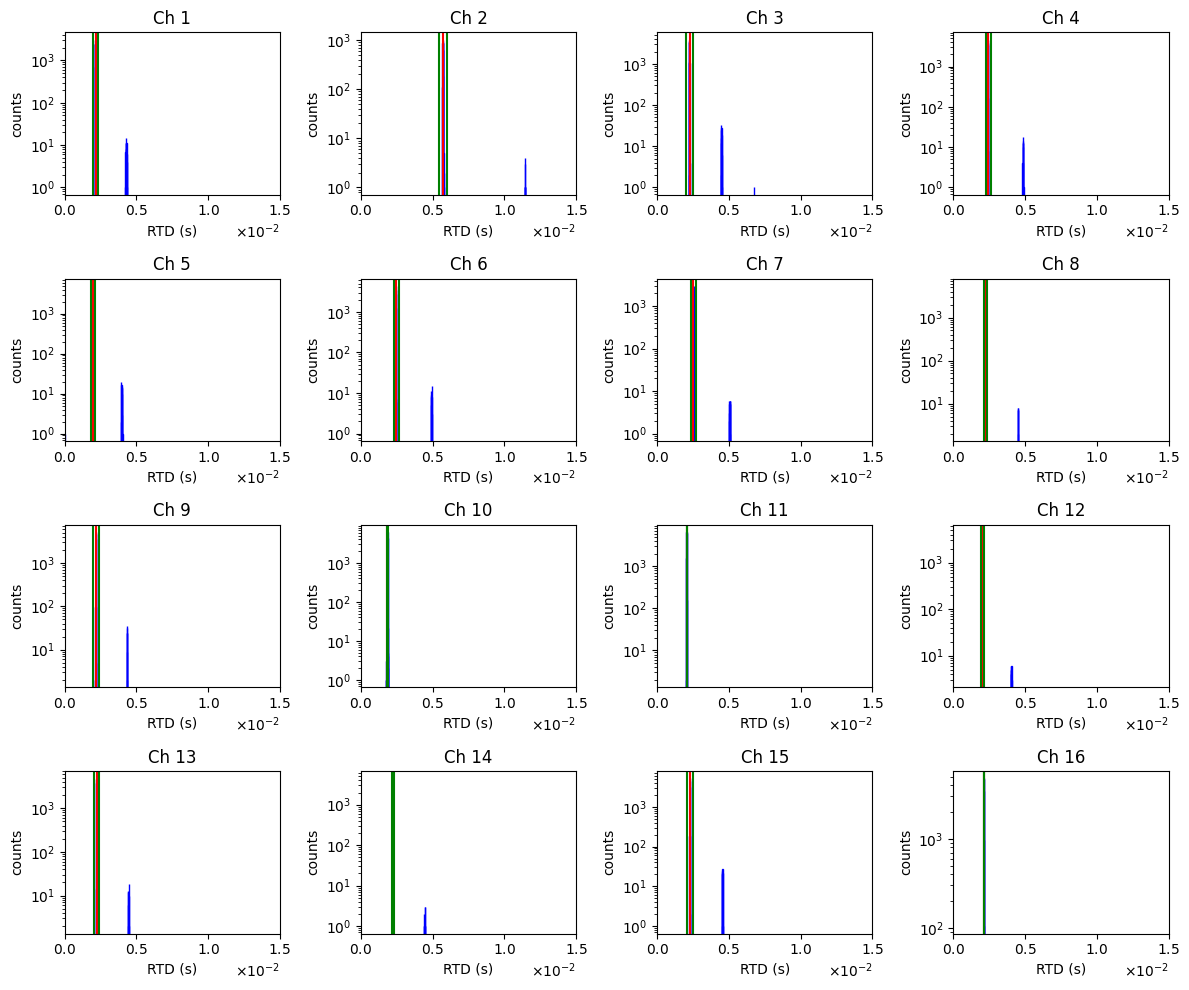

In [7]:
# Create a figure with a 3x5 grid of subplots
fig, axes = plt.subplots(4, 4, figsize=(12, 10))

j=1

mean_charge = [] # To store the mean charge per reset for each channel
std_charge = [] # To store the standard deviation for the mean charge per reset for each channel

# Iterate through each time data array and plot the time differences
for i in range(len(timestamps_list)):
    row = i // 4
    col = i % 4
    ax = axes[row, col]

    # Calculate time differences between adjacent data points
    rtd = np.diff(timestamps_list[i])

    # Set lower and upper cutoffs for the data
    lower_cutoff = 5e-5  # Example lower cutoff
    upper_cutoff = 50e-3  # Example upper cutoff

# Apply conditional filtering to keep only the data within the desired range
    filtered_rtd = rtd[(rtd >= lower_cutoff) & (rtd <= upper_cutoff)]
    #print(filtered_rtd[:100]*1000) #ms

    mean_rtd = np.mean(filtered_rtd)
    std_rtd = np.std(filtered_rtd)

#Calcuate the mean charge per reset for each channel
    input_current = 5000 #pA
    mean_Q = mean_rtd * input_current # The charge is in pC since rtd is in s and current is in pA
    std_Q = std_rtd * input_current

    mean_charge.append(mean_Q)
    std_charge.append(std_Q)

    print("ch", j, " ,mean rtd: ",  mean_rtd*1000, " ,std rtd: ", std_rtd*1000)
    #print("ch", j, " ,mean charge: ",  mean_Q, " ,std charge: ", std_Q)
    j = j+1



# Create a histogram of the filtered differences

    # Create a histogram of time differences
    ax.hist(filtered_rtd, bins=2000,range=(0, 0.02), color='blue', alpha=1, edgecolor='blue')
    ax.axvline(mean_rtd, color = 'red')
    ax.axvline(mean_rtd-std_rtd , color = 'green')
    ax.axvline(mean_rtd+std_rtd, color = 'green')
    
    # Configure the x-axis formatter to use scientific notation
    ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.ticklabel_format(axis='x', style='sci', scilimits=(0,0))  # Apply scientific notation

     # Add titles (labels) to x and y axes
    ax.set_xlabel('RTD (s)')  # Replace with your desired x-axis label
    ax.set_ylabel('counts')  # Replace with your desired y-axis label

    # Define your desired x-axis range
    x_min = 0 # Replace with your desired minimum x-axis value
    x_max = 15e-3  # Replace with your desired maximum x-axis value

     # Set the x-axis range
    ax.set_xlim(x_min, x_max)
    ax.set_yscale('log')
    ax.set_title(f'Ch {i + 1}')

plt.tight_layout()
plt.show()

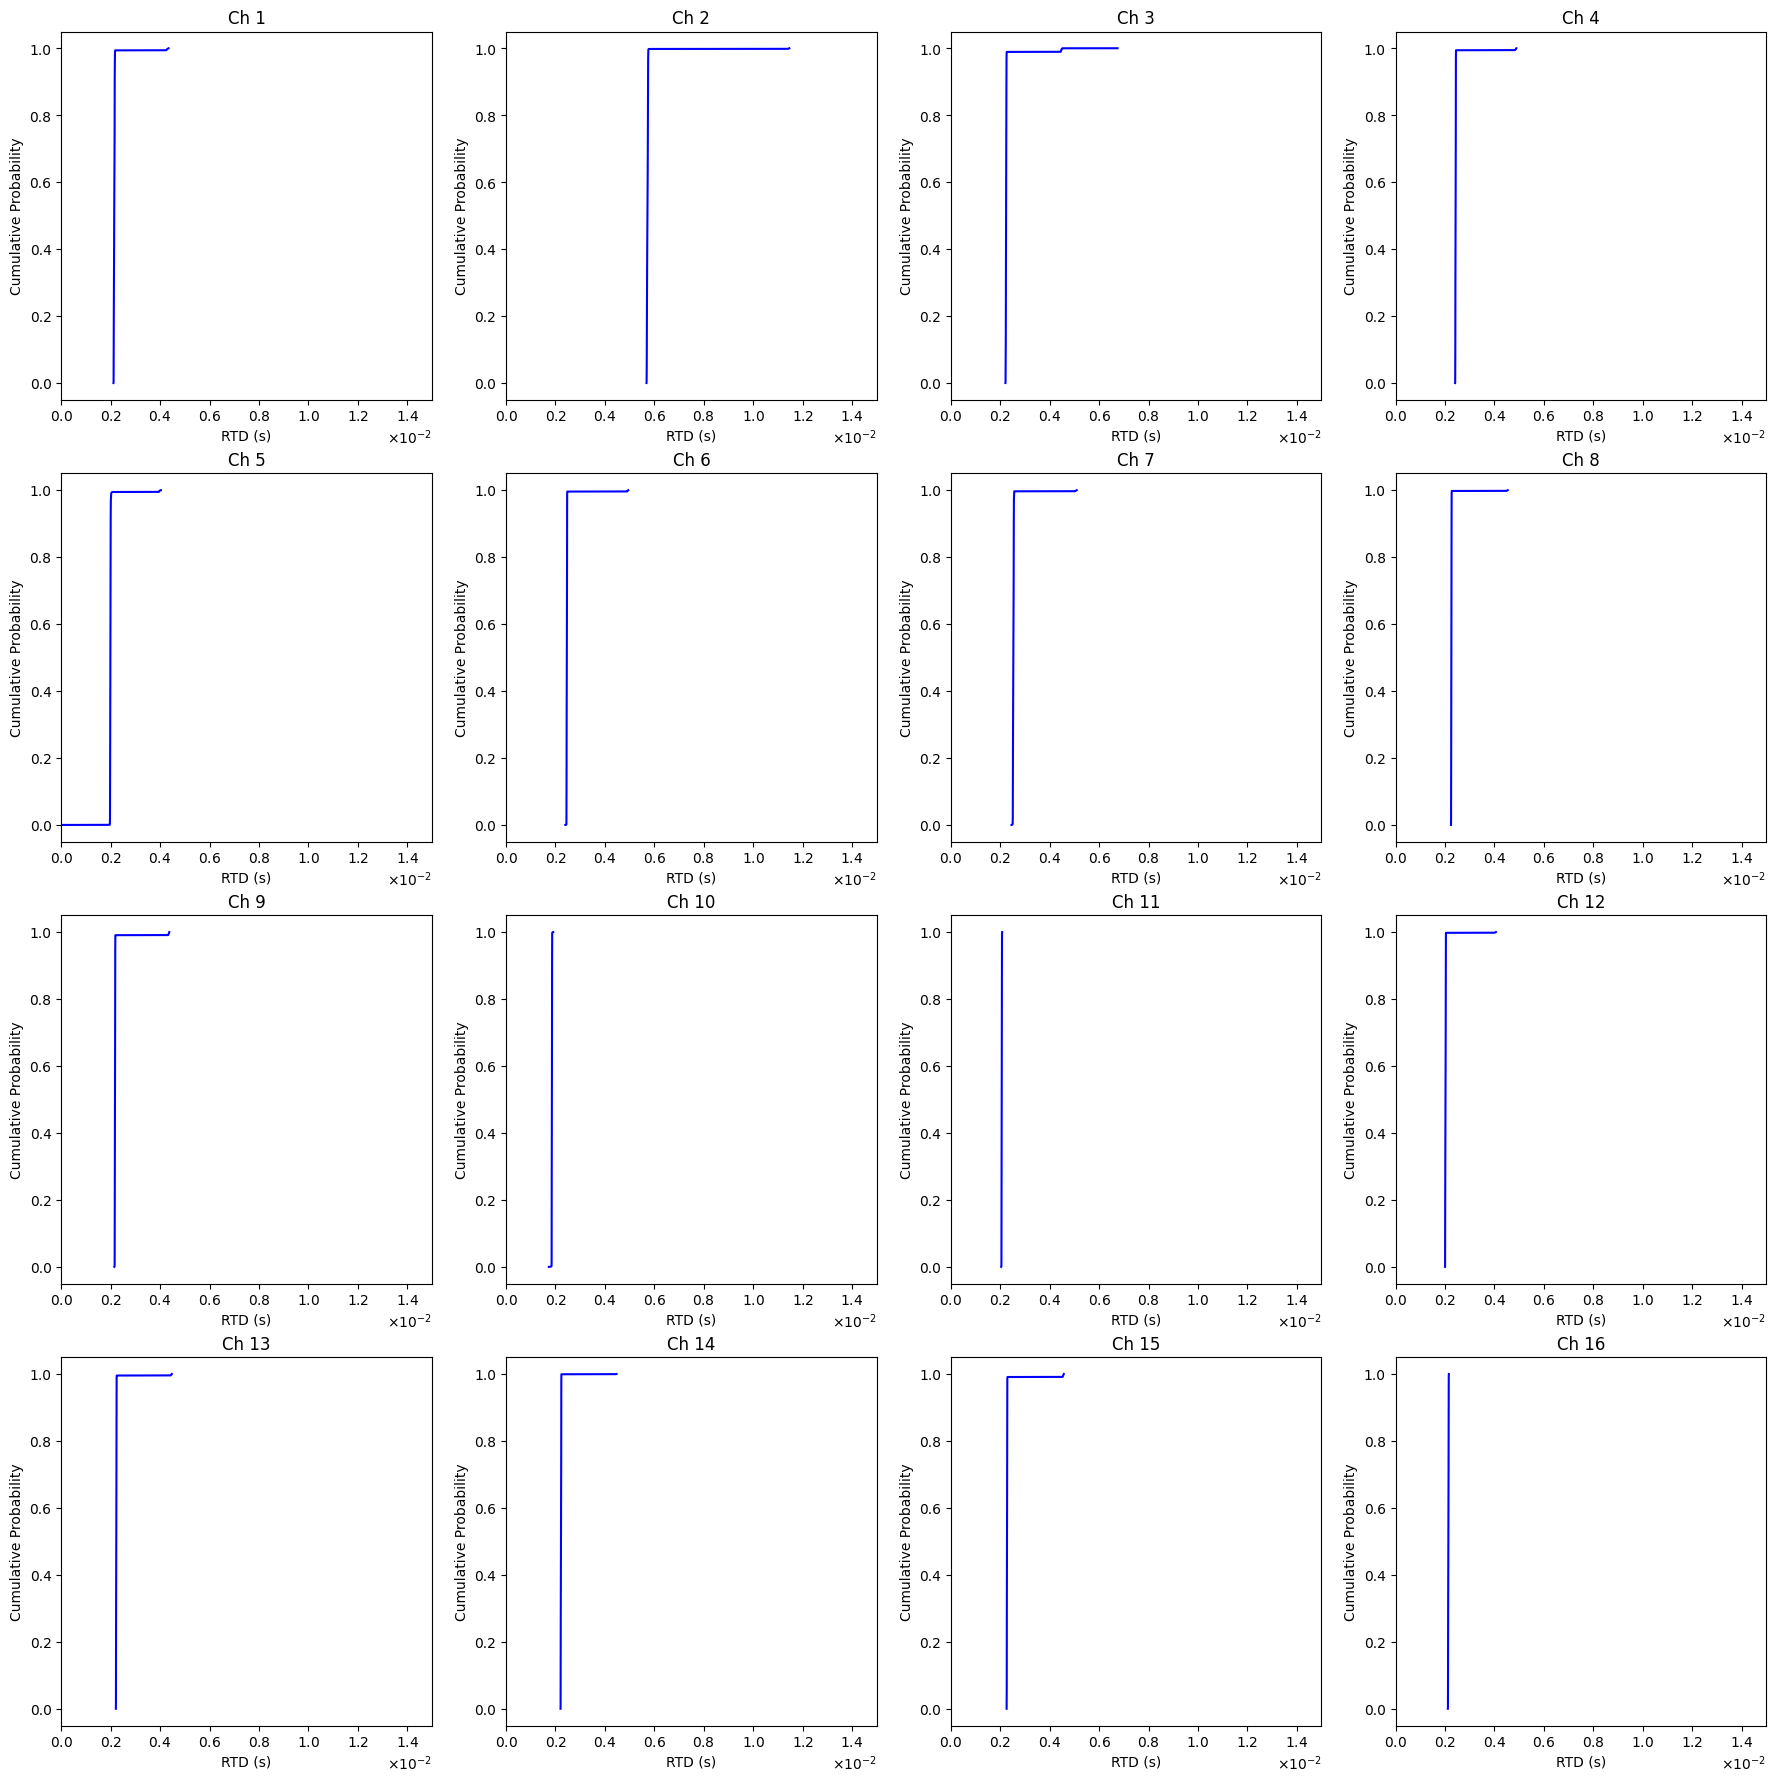

In [5]:
# Create a figure with a 3x5 grid of subplots
fig, axes = plt.subplots(4, 4, figsize=(22, 22))

# Iterate through each time data array and plot the time differences
for i in range(len(timestamps_list)):
    row = i // 4
    col = i % 4
    ax = axes[row, col]

    # Calculate time differences between adjacent data points
    rtd = np.diff(timestamps_list[i])

    # Set lower and upper cutoffs for the data
    lower_cutoff = 5e-5  # Example lower cutoff
    upper_cutoff = 50e-3  # Example upper cutoff

# Apply conditional filtering to keep only the data within the desired range
    filtered_rtd = rtd[(rtd >= lower_cutoff) & (rtd <= upper_cutoff)]

 # Calculate the cumulative distribution
    sorted_rtd = np.sort(filtered_rtd)
    cumulative_prob = np.arange(1, len(sorted_rtd) + 1) / len(sorted_rtd)

    ax.plot(sorted_rtd, cumulative_prob, color='blue')

    
    # Add labels and a title
    ax.set_xlabel('RTD (s)')
    ax.set_ylabel('Cumulative Probability')
    ax.set_title(f'Ch {i+1}')

    # Configure the x-axis formatter to use scientific notation
    ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))

    # Define your desired x-axis range
    x_min = 0  # Replace with your desired minimum x-axis value
    x_max = 15e-3  # Replace with your desired maximum x-axis value

    # Set the x-axis range
    ax.set_xlim(x_min, x_max)

[10.781642397428467, 28.66598395009392, 11.300158421917185, 12.204064364650781, 9.99038411420983, 12.345702890902933, 12.687779572009312, 11.301945552488542, 10.966609181509416, 9.270935446765147, 10.292889316920633, 10.113196670680582, 11.1785051573399, 11.120305814467272, 11.465562799705092, 10.668805424995686]
[0.96719958 0.91146357 0.84211209 0.9636134  0.90687204 0.92501821
 0.93444246 0.92550437 0.88340889 0.94186828 0.89148923 0.91761293
 0.90101493 0.91903947 0.90078439 0.94743503]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
The average charege per reset is:  12.147154442255294 pC
The average charege per reset is:  11.1395 pC


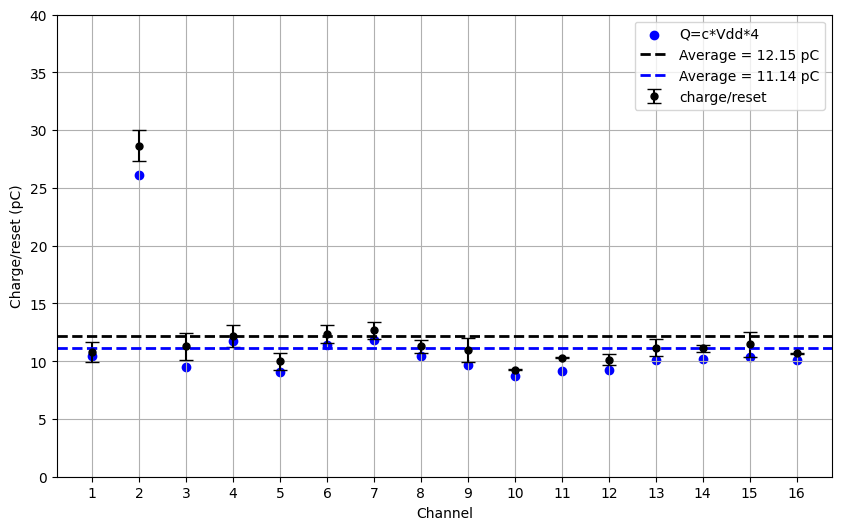

In [8]:
##################################################################################################
# Compare the charge Q defined by the C*Vdd and I*RTD, where C =10 pF is the feedback          ###
# capacitance, Vdd is the measured threshold voltage of the comparator, and I is the input     ###                                                ###
# constant current, RTD is the mean reset time differece determined from the measured RTD      ###
#  distributions                                                                               ###
##################################################################################################

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(10, 6))

# measured Vdd, Q_vdd = C*Vdd*4, where 
Q_vdd = [10.428, 26.128, 9.516, 11.76, 9.06, 11.42, 11.856, 10.46, 9.688, 8.732, 9.176, 9.28, 10.072, 10.22, 10.328, 10.108] #calculated charge per reset from C*Vdd*4, where Vdd are measurements for ch 2 to 14
print(mean_charge)
print (np.array(Q_vdd)/np.array(mean_charge)) #Reconstructed current/input current

# Define the range of channels to plot
start_channel = 1  # Start channel
end_channel = 16  # End channel

# Create a list of channel numbers within the specified range
x_channels = list(range(start_channel, end_channel+1))
print(x_channels)


# Plot the average charge per reset with error bars
ax.errorbar(x_channels, mean_charge, yerr=std_charge, fmt='o', color='black', markersize=5, capsize=5, label='charge/reset')
plt.scatter(x_channels, Q_vdd, label='Q=c*Vdd*4', color='b', marker='o')

# Calculate the average charge of the mean charge for 10 channels
avg_charge_1 = np.mean(mean_charge) #average charge = average rtd in second* 5 nA
avg_charge_2 = np.mean(Q_vdd) #average charge = average rtd in second* 5 nA

# Plot a flat line at the calculated average value
ax.axhline(avg_charge_1, color='black', linestyle='--', label='Average = 12.15 pC', linewidth=2)
ax.axhline(avg_charge_2, color='blue', linestyle='--', label='Average = 11.14 pC', linewidth=2)

print("The average charege per reset is: ", avg_charge_1, "pC")
print("The average charege per reset is: ", avg_charge_2, "pC")

# Configure the x-axis formatter to use integers
ax.set_xticks(x_channels)

# Add labels to x and y axes
ax.set_xlabel('Channel')
ax.set_ylabel('Charge/reset (pC)')

# Show the legend
plt.legend()

# Show the plot

plt.plot()

# Set the x-axis and y-axis range and labels
#ax.set_xlim(start_channel-0.1 , end_channel)
ax.set_ylim(0, 40)  
ax.grid(True)

# Show the legend
ax.legend()

# Show the plot
plt.show()

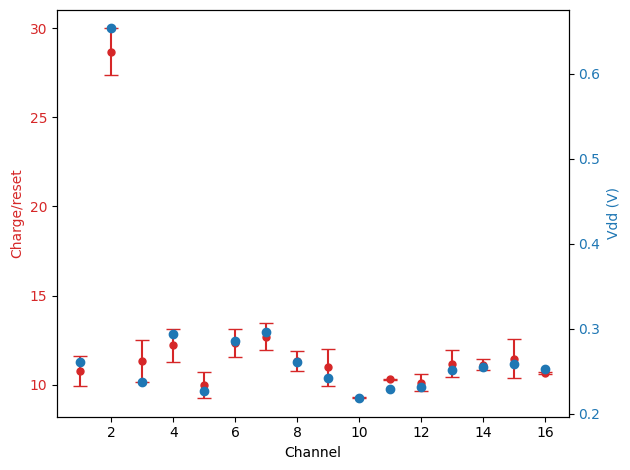

In [9]:
#########################################################################
# Charge/reset vs channels
# Vdd vs. channels
# purpose: find out if the trend of charge/reset vs channels is mainly ###
#          dependent on the vdd distribution.                          ###
##########################################################################
fig, ax1 = plt.subplots()
Vdd = [0.2607, 0.6532, 0.2379, 0.294, 0.2265, 0.2855, 0.2964, 0.2615, 0.2422, 0.2183, 0.2294, 0.232,0.2518, 0.2555,0.2582,0.2527]

color = 'tab:red'
ax1.set_xlabel('Channel')
ax1.set_ylabel('Charge/reset', color=color)
ax1.errorbar(x_channels, mean_charge, yerr=std_charge, fmt='o', color=color, markersize=5, capsize=5, label='charge/reset')

ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Vdd (V)', color=color)  # we already handled the x-label with ax1
ax2.scatter(x_channels, Vdd, label='Q=c*Vdd*4', color=color, marker='o')
#ax2.plot(x_channels, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()